# Implementation of Wasserstein GAN on Celeba dataset - V2

This notebook illustrates that the way to create simple WGAN architecture. Implementation is influenced from the assignments given in the [GAN specialization on Coursera](https://www.coursera.org/specializations/generative-adversarial-networks-gans?)

* WANDB project name : 'test2: without_init_weights + bigger dataset'
* WANDB project link : https://wandb.ai/hobby_projects/WGAN_implementation?workspace=user-hobby_projects
* training was done on entire dataset


In [ ]:
import torch
import numpy as np
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##1. Download the Dataset (CelebA)

In [ ]:
import zipfile
import os
if not os.path.isfile('celeba.zip'):
  !mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
  with zipfile.ZipFile("celeba.zip","r") as zip_ref:
    zip_ref.extractall("data_faces/")

--2021-01-19 14:22:22--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.8
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  21.4MB/s    in 67s     

2021-01-19 14:23:30 (20.4 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



##2. Define Parameters

In [ ]:
lr=0.0002
noise_channels=256
img_channels=3
img_size=64
hidden_G=16
hidden_C=16
batch_size=128
epochs=50

##3. Preparing the Dataset

In [ ]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
                               transforms.Resize((img_size,img_size)),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder('data_faces', transform=transform)
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

##4. Defining Support Blocks


In [ ]:
class conv_trans_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernal_size=4,stride=2,padding=1):
    super(conv_trans_block,self).__init__()
    self.block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernal_size,stride,padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())
  def forward(self,x):
    return self.block(x)

class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernal_size=4,stride=2,padding=1):
    super(conv_block,self).__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernal_size,stride,padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2))
  def forward(self,x):
    return self.block(x)

##5. Defining Generator and Discriminator

In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_channels,img_channels,hidden_G):
    super(Generator,self).__init__()
    self.G=nn.Sequential(
        conv_trans_block(noise_channels,hidden_G*16,kernal_size=4,stride=1,padding=0),
        conv_trans_block(hidden_G*16,hidden_G*8),
        conv_trans_block(hidden_G*8,hidden_G*4),
        conv_trans_block(hidden_G*4,hidden_G*2),
        nn.ConvTranspose2d(hidden_G*2,img_channels,kernel_size=4,stride=2,padding=1),
        nn.Tanh()
    )
  def forward(self,x):
    return self.G(x)

class Critic(nn.Module):
  def __init__(self,img_channels,hidden_D):
    super(Critic,self).__init__()
    self.D=nn.Sequential(
        conv_block(img_channels,hidden_G),
        conv_block(hidden_G,hidden_G*2),
        conv_block(hidden_G*2,hidden_G*4),
        conv_block(hidden_G*4,hidden_G*8),
        nn.Conv2d(hidden_G*8,1,kernel_size=4,stride=2,padding=0))
    
  def forward(self,x):
    return self.D(x)

##6. Creating the GAN


1.   Create Discriminator and the Generator
2.   Select **Binary Cross Entropy** as the Loss (which can be used as the losses of both Generator and Discriminator)
3.   Select **Adam** optimizer as optimizers for both Generator and Discriminator

Model architectures can be seen below

In [ ]:
C=Critic(img_channels,hidden_C).to(device)
G=Generator(noise_channels,img_channels,hidden_G).to(device)

print('Critic :')
summary(C,(img_channels,img_size,img_size))
print('Generator :')
summary(G,(noise_channels,1,1))

opt_C=torch.optim.Adam(C.parameters(),lr=lr, betas=(0.5,0.999))
opt_G=torch.optim.Adam(G.parameters(),lr=lr, betas=(0.5,0.999))

Critic :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             784
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
        conv_block-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]           8,224
       BatchNorm2d-6           [-1, 32, 16, 16]              64
         LeakyReLU-7           [-1, 32, 16, 16]               0
        conv_block-8           [-1, 32, 16, 16]               0
            Conv2d-9             [-1, 64, 8, 8]          32,832
      BatchNorm2d-10             [-1, 64, 8, 8]             128
        LeakyReLU-11             [-1, 64, 8, 8]               0
       conv_block-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         131,200
      BatchNorm2d-14          

##7. Training and Generating Images

In [ ]:
import os

try:os.mkdir('latest_model')
except:pass

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

def get_gradient(crit, real_imgs, fake_imgs, epsilon):

  mixed_imgs= real_imgs* epsilon + fake_imgs*(1- epsilon)
  mixed_scores= crit(mixed_imgs)

  gradient= torch.autograd.grad(outputs= mixed_scores,
                                inputs= mixed_imgs,
                                grad_outputs= torch.ones_like(mixed_scores),
                                create_graph=True,
                                retain_graph=True)[0]
  return gradient

def gradient_penalty(gradient):
  gradient= gradient.view(len(gradient), -1)
  gradient_norm= gradient.norm(2, dim=1)
  penalty = torch.nn.MSELoss()(gradient_norm, torch.ones_like(gradient_norm))
  return penalty

def get_gen_loss(crit_fake_pred):
  gen_loss= -torch.mean(crit_fake_pred)
  return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gradient_penalty, c_lambda):
  crit_loss= torch.mean(crit_fake_pred)- torch.mean(crit_real_pred)+ c_lambda* gradient_penalty
  return crit_loss

In [ ]:
!!pip install wandb -qqq

import wandb
wandb.login()
def save_model_as_checkpoint_wfdb(epoch, model, optimizer, loss, path, run, artifact):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path)

    artifact.add_file(path)
    run.log_artifact(artifact)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
name='test2: without_init_weights + bigger dataset'
run=wandb.init(project='WGAN_implementation' , name=name)

wandb: Currently logged in as: hobby_projects (use `wandb login --relogin` to force relogin)


epoch:1/50 iteration:0/202599 Loss C :1.5476667881011963 -- Loss G :0.1375838965177536
epoch:1/50 iteration:100/202599 Loss C :-6.512505531311035 -- Loss G :3.1374239921569824
epoch:1/50 iteration:200/202599 Loss C :-8.043512344360352 -- Loss G :7.135979652404785
epoch:1/50 iteration:300/202599 Loss C :-7.411259651184082 -- Loss G :7.362240791320801
epoch:1/50 iteration:400/202599 Loss C :-7.070172309875488 -- Loss G :10.362741470336914
epoch:1/50 iteration:500/202599 Loss C :-4.413700580596924 -- Loss G :12.933979988098145
epoch:1/50 iteration:600/202599 Loss C :-5.996959209442139 -- Loss G :10.230239868164062
epoch:1/50 iteration:700/202599 Loss C :-5.614034175872803 -- Loss G :12.928498268127441
epoch:1/50 iteration:800/202599 Loss C :-4.893000602722168 -- Loss G :13.903629302978516
epoch:1/50 iteration:900/202599 Loss C :-4.892805099487305 -- Loss G :12.67933464050293
epoch:1/50 iteration:1000/202599 Loss C :-4.418360710144043 -- Loss G :13.976553916931152
epoch:1/50 iteration:1100

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

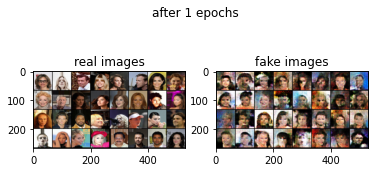

epoch:2/50 iteration:0/202599 Loss C :-3.8345494270324707 -- Loss G :17.923892974853516
epoch:2/50 iteration:100/202599 Loss C :-5.375364303588867 -- Loss G :17.360034942626953
epoch:2/50 iteration:200/202599 Loss C :-3.9869272708892822 -- Loss G :17.126955032348633
epoch:2/50 iteration:300/202599 Loss C :-4.765786647796631 -- Loss G :12.838966369628906
epoch:2/50 iteration:400/202599 Loss C :-4.785549163818359 -- Loss G :21.025272369384766
epoch:2/50 iteration:500/202599 Loss C :-4.540604114532471 -- Loss G :17.646800994873047
epoch:2/50 iteration:600/202599 Loss C :-3.5403575897216797 -- Loss G :16.245403289794922
epoch:2/50 iteration:700/202599 Loss C :-3.6452884674072266 -- Loss G :16.14910888671875
epoch:2/50 iteration:800/202599 Loss C :-2.3856287002563477 -- Loss G :10.645886421203613
epoch:2/50 iteration:900/202599 Loss C :-3.6520047187805176 -- Loss G :16.62253761291504
epoch:2/50 iteration:1000/202599 Loss C :-3.960153102874756 -- Loss G :14.757430076599121
epoch:2/50 iterati

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

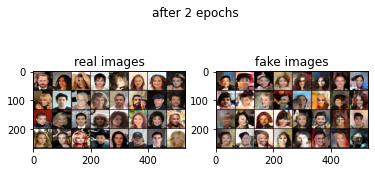

epoch:3/50 iteration:0/202599 Loss C :-3.039013624191284 -- Loss G :13.0592041015625
epoch:3/50 iteration:100/202599 Loss C :-3.1191062927246094 -- Loss G :17.1724910736084
epoch:3/50 iteration:200/202599 Loss C :-2.4593212604522705 -- Loss G :12.327858924865723
epoch:3/50 iteration:300/202599 Loss C :-4.874639511108398 -- Loss G :23.39676284790039
epoch:3/50 iteration:400/202599 Loss C :-3.104858875274658 -- Loss G :16.335342407226562
epoch:3/50 iteration:500/202599 Loss C :-4.421862602233887 -- Loss G :12.171102523803711
epoch:3/50 iteration:600/202599 Loss C :-3.217282295227051 -- Loss G :20.238746643066406
epoch:3/50 iteration:700/202599 Loss C :-4.196189880371094 -- Loss G :18.415660858154297
epoch:3/50 iteration:800/202599 Loss C :-4.509660720825195 -- Loss G :19.387744903564453
epoch:3/50 iteration:900/202599 Loss C :-3.5969486236572266 -- Loss G :18.473873138427734
epoch:3/50 iteration:1000/202599 Loss C :-3.5883750915527344 -- Loss G :21.179153442382812
epoch:3/50 iteration:11

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

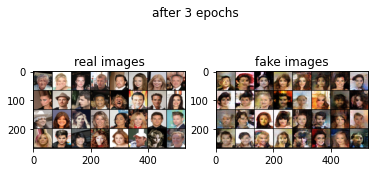

epoch:4/50 iteration:0/202599 Loss C :-5.685300350189209 -- Loss G :10.496292114257812
epoch:4/50 iteration:100/202599 Loss C :-5.034241199493408 -- Loss G :14.843965530395508
epoch:4/50 iteration:200/202599 Loss C :-4.123422622680664 -- Loss G :18.419252395629883
epoch:4/50 iteration:300/202599 Loss C :-1.812150478363037 -- Loss G :17.549379348754883
epoch:4/50 iteration:400/202599 Loss C :-6.033382892608643 -- Loss G :9.451105117797852
epoch:4/50 iteration:500/202599 Loss C :-4.490530490875244 -- Loss G :24.507564544677734
epoch:4/50 iteration:600/202599 Loss C :-1.8091543912887573 -- Loss G :19.198829650878906
epoch:4/50 iteration:700/202599 Loss C :-2.8995862007141113 -- Loss G :13.387929916381836
epoch:4/50 iteration:800/202599 Loss C :-3.84665584564209 -- Loss G :17.84516143798828
epoch:4/50 iteration:900/202599 Loss C :-2.6958906650543213 -- Loss G :20.48076629638672
epoch:4/50 iteration:1000/202599 Loss C :-2.4491734504699707 -- Loss G :18.210342407226562
epoch:4/50 iteration:1

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

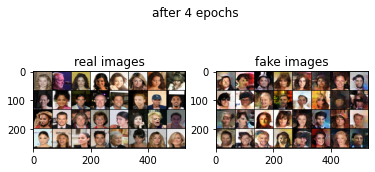

epoch:5/50 iteration:0/202599 Loss C :-0.8883942365646362 -- Loss G :8.770687103271484
epoch:5/50 iteration:100/202599 Loss C :-2.3645007610321045 -- Loss G :16.94415283203125
epoch:5/50 iteration:200/202599 Loss C :-4.203114032745361 -- Loss G :26.55088233947754
epoch:5/50 iteration:300/202599 Loss C :-2.5521252155303955 -- Loss G :13.21363639831543
epoch:5/50 iteration:400/202599 Loss C :-2.866830348968506 -- Loss G :14.853729248046875
epoch:5/50 iteration:500/202599 Loss C :-2.32291316986084 -- Loss G :9.80471420288086
epoch:5/50 iteration:600/202599 Loss C :-2.3391685485839844 -- Loss G :17.938480377197266
epoch:5/50 iteration:700/202599 Loss C :-2.036775588989258 -- Loss G :19.355859756469727
epoch:5/50 iteration:800/202599 Loss C :-2.503016233444214 -- Loss G :14.403879165649414
epoch:5/50 iteration:900/202599 Loss C :-1.9840656518936157 -- Loss G :22.14939308166504
epoch:5/50 iteration:1000/202599 Loss C :-2.019188404083252 -- Loss G :16.48989486694336
epoch:5/50 iteration:1100/

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

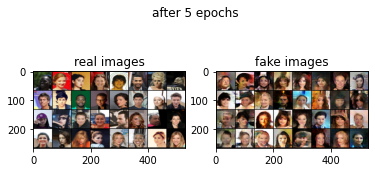

epoch:6/50 iteration:0/202599 Loss C :-1.7276631593704224 -- Loss G :10.482627868652344
epoch:6/50 iteration:100/202599 Loss C :-1.9207420349121094 -- Loss G :14.504179954528809
epoch:6/50 iteration:200/202599 Loss C :-2.2500059604644775 -- Loss G :21.186477661132812
epoch:6/50 iteration:300/202599 Loss C :-1.808007001876831 -- Loss G :18.10519790649414
epoch:6/50 iteration:400/202599 Loss C :-1.1438093185424805 -- Loss G :17.11847686767578
epoch:6/50 iteration:500/202599 Loss C :-1.835564136505127 -- Loss G :14.832977294921875
epoch:6/50 iteration:600/202599 Loss C :-1.6790368556976318 -- Loss G :14.627466201782227
epoch:6/50 iteration:700/202599 Loss C :-1.4119043350219727 -- Loss G :19.47272300720215
epoch:6/50 iteration:800/202599 Loss C :-2.0460455417633057 -- Loss G :14.744146347045898
epoch:6/50 iteration:900/202599 Loss C :-1.9148688316345215 -- Loss G :16.02141761779785
epoch:6/50 iteration:1000/202599 Loss C :-1.9821754693984985 -- Loss G :14.04427719116211
epoch:6/50 iterati

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

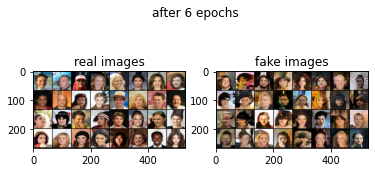

epoch:7/50 iteration:0/202599 Loss C :-1.7285524606704712 -- Loss G :25.189252853393555
epoch:7/50 iteration:100/202599 Loss C :-2.803758144378662 -- Loss G :15.66739273071289
epoch:7/50 iteration:200/202599 Loss C :-1.108687162399292 -- Loss G :18.323745727539062
epoch:7/50 iteration:300/202599 Loss C :-1.3724286556243896 -- Loss G :17.39844512939453
epoch:7/50 iteration:400/202599 Loss C :-0.9299865365028381 -- Loss G :17.965478897094727
epoch:7/50 iteration:500/202599 Loss C :-1.918928623199463 -- Loss G :18.087997436523438
epoch:7/50 iteration:600/202599 Loss C :-1.2004516124725342 -- Loss G :17.2481746673584
epoch:7/50 iteration:700/202599 Loss C :-1.2917380332946777 -- Loss G :18.185836791992188
epoch:7/50 iteration:800/202599 Loss C :-2.851400375366211 -- Loss G :14.702608108520508
epoch:7/50 iteration:900/202599 Loss C :-2.202342987060547 -- Loss G :19.77272605895996
epoch:7/50 iteration:1000/202599 Loss C :-4.221917152404785 -- Loss G :24.27178955078125
epoch:7/50 iteration:11

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

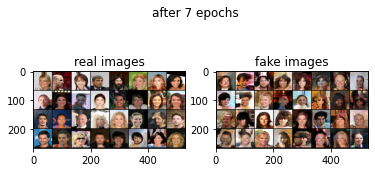

epoch:8/50 iteration:0/202599 Loss C :-2.3705697059631348 -- Loss G :18.587072372436523
epoch:8/50 iteration:100/202599 Loss C :-3.0313429832458496 -- Loss G :13.594188690185547
epoch:8/50 iteration:200/202599 Loss C :-2.0425631999969482 -- Loss G :25.369503021240234
epoch:8/50 iteration:300/202599 Loss C :-0.9833202958106995 -- Loss G :21.88426971435547
epoch:8/50 iteration:400/202599 Loss C :-2.4636025428771973 -- Loss G :15.88148307800293
epoch:8/50 iteration:500/202599 Loss C :-0.2764884829521179 -- Loss G :13.489818572998047
epoch:8/50 iteration:600/202599 Loss C :-1.6624364852905273 -- Loss G :21.007320404052734
epoch:8/50 iteration:700/202599 Loss C :-2.8562726974487305 -- Loss G :18.250869750976562
epoch:8/50 iteration:800/202599 Loss C :-2.086116313934326 -- Loss G :15.967531204223633
epoch:8/50 iteration:900/202599 Loss C :-4.279070854187012 -- Loss G :12.475895881652832
epoch:8/50 iteration:1000/202599 Loss C :-1.9260591268539429 -- Loss G :17.869373321533203
epoch:8/50 iter

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

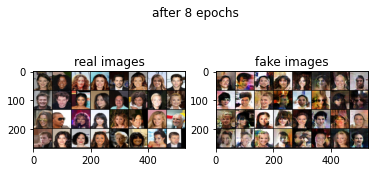

epoch:9/50 iteration:0/202599 Loss C :-1.5077738761901855 -- Loss G :19.613073348999023
epoch:9/50 iteration:100/202599 Loss C :-1.0718371868133545 -- Loss G :17.248878479003906
epoch:9/50 iteration:200/202599 Loss C :-1.7353019714355469 -- Loss G :18.40554428100586
epoch:9/50 iteration:300/202599 Loss C :-0.818695068359375 -- Loss G :14.992057800292969
epoch:9/50 iteration:400/202599 Loss C :-1.5299501419067383 -- Loss G :21.950786590576172
epoch:9/50 iteration:500/202599 Loss C :-1.7618134021759033 -- Loss G :20.243396759033203
epoch:9/50 iteration:600/202599 Loss C :-1.2174973487854004 -- Loss G :23.9517879486084
epoch:9/50 iteration:700/202599 Loss C :-1.0160504579544067 -- Loss G :16.667755126953125
epoch:9/50 iteration:800/202599 Loss C :-1.9872970581054688 -- Loss G :25.744586944580078
epoch:9/50 iteration:900/202599 Loss C :-1.5710183382034302 -- Loss G :19.390775680541992
epoch:9/50 iteration:1000/202599 Loss C :-1.0982143878936768 -- Loss G :16.750028610229492
epoch:9/50 iter

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

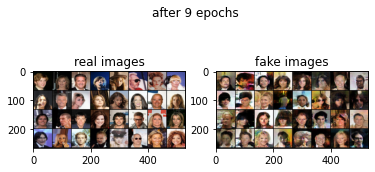

epoch:10/50 iteration:0/202599 Loss C :-0.7686335444450378 -- Loss G :12.56936264038086
epoch:10/50 iteration:100/202599 Loss C :-0.7761077284812927 -- Loss G :14.55396842956543
epoch:10/50 iteration:200/202599 Loss C :-1.8754442930221558 -- Loss G :21.63564682006836
epoch:10/50 iteration:300/202599 Loss C :-2.504502534866333 -- Loss G :18.390522003173828
epoch:10/50 iteration:400/202599 Loss C :-0.6103873252868652 -- Loss G :12.87678337097168
epoch:10/50 iteration:500/202599 Loss C :-0.5771399140357971 -- Loss G :12.179157257080078
epoch:10/50 iteration:600/202599 Loss C :-0.20130473375320435 -- Loss G :13.242652893066406
epoch:10/50 iteration:700/202599 Loss C :-0.8934948444366455 -- Loss G :17.573888778686523
epoch:10/50 iteration:800/202599 Loss C :-1.5906144380569458 -- Loss G :22.498363494873047
epoch:10/50 iteration:900/202599 Loss C :-0.731083869934082 -- Loss G :18.56900405883789
epoch:10/50 iteration:1000/202599 Loss C :-1.1414055824279785 -- Loss G :17.892684936523438
epoch:

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

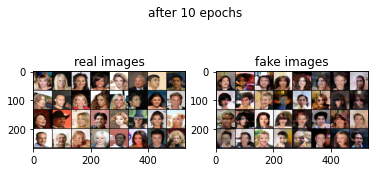

epoch:11/50 iteration:0/202599 Loss C :0.302409827709198 -- Loss G :2.6672544479370117
epoch:11/50 iteration:100/202599 Loss C :-1.2139207124710083 -- Loss G :11.774904251098633
epoch:11/50 iteration:200/202599 Loss C :-0.44576311111450195 -- Loss G :6.982845783233643
epoch:11/50 iteration:300/202599 Loss C :-0.06186673045158386 -- Loss G :-0.46066805720329285
epoch:11/50 iteration:400/202599 Loss C :-1.0555577278137207 -- Loss G :5.93663215637207
epoch:11/50 iteration:500/202599 Loss C :-1.075790524482727 -- Loss G :4.732781410217285
epoch:11/50 iteration:600/202599 Loss C :-0.6393953561782837 -- Loss G :9.422140121459961
epoch:11/50 iteration:700/202599 Loss C :-0.45656582713127136 -- Loss G :7.59066104888916
epoch:11/50 iteration:800/202599 Loss C :-0.8546685576438904 -- Loss G :9.362457275390625
epoch:11/50 iteration:900/202599 Loss C :-1.1135945320129395 -- Loss G :2.0319056510925293
epoch:11/50 iteration:1000/202599 Loss C :-0.37712180614471436 -- Loss G :11.781511306762695
epoch

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

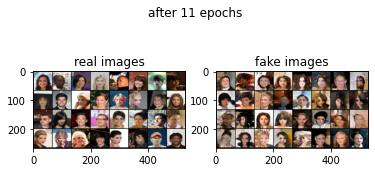

epoch:12/50 iteration:0/202599 Loss C :-1.1847271919250488 -- Loss G :3.631289005279541
epoch:12/50 iteration:100/202599 Loss C :-0.5421711206436157 -- Loss G :0.3974229693412781
epoch:12/50 iteration:200/202599 Loss C :-1.5045037269592285 -- Loss G :-4.043285846710205
epoch:12/50 iteration:300/202599 Loss C :-0.2661955952644348 -- Loss G :-1.0823315382003784
epoch:12/50 iteration:400/202599 Loss C :-1.4512754678726196 -- Loss G :-7.48494291305542
epoch:12/50 iteration:500/202599 Loss C :0.08403684198856354 -- Loss G :-3.6201605796813965
epoch:12/50 iteration:600/202599 Loss C :-0.1593354344367981 -- Loss G :2.455214023590088
epoch:12/50 iteration:700/202599 Loss C :-1.049601435661316 -- Loss G :1.6929867267608643
epoch:12/50 iteration:800/202599 Loss C :0.5656801462173462 -- Loss G :-8.19650936126709
epoch:12/50 iteration:900/202599 Loss C :-2.2729005813598633 -- Loss G :1.4155066013336182
epoch:12/50 iteration:1000/202599 Loss C :1.099890947341919 -- Loss G :2.0867538452148438
epoch:

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

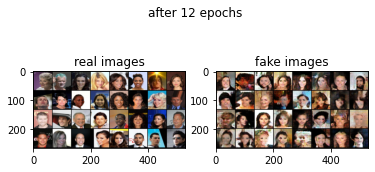

epoch:13/50 iteration:0/202599 Loss C :-2.661231756210327 -- Loss G :-0.9067589640617371
epoch:13/50 iteration:100/202599 Loss C :-3.855576992034912 -- Loss G :-5.019015789031982
epoch:13/50 iteration:200/202599 Loss C :-0.5088416934013367 -- Loss G :-9.834041595458984
epoch:13/50 iteration:300/202599 Loss C :-0.2384777069091797 -- Loss G :-7.233226776123047
epoch:13/50 iteration:400/202599 Loss C :-1.6444735527038574 -- Loss G :-7.46861457824707
epoch:13/50 iteration:500/202599 Loss C :-1.4806774854660034 -- Loss G :-3.4437263011932373
epoch:13/50 iteration:600/202599 Loss C :0.1673809140920639 -- Loss G :-2.8656809329986572
epoch:13/50 iteration:700/202599 Loss C :-0.8994641900062561 -- Loss G :-7.6324896812438965
epoch:13/50 iteration:800/202599 Loss C :-0.8055108189582825 -- Loss G :3.03928279876709
epoch:13/50 iteration:900/202599 Loss C :-0.7450518608093262 -- Loss G :-5.738544464111328
epoch:13/50 iteration:1000/202599 Loss C :-0.23068520426750183 -- Loss G :-3.933053493499756
e

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

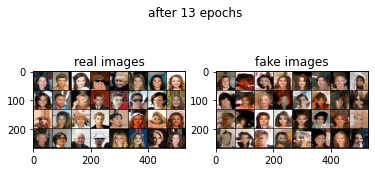

epoch:14/50 iteration:0/202599 Loss C :-1.3305063247680664 -- Loss G :-2.191457986831665
epoch:14/50 iteration:100/202599 Loss C :-4.488460540771484 -- Loss G :-1.6346652507781982
epoch:14/50 iteration:200/202599 Loss C :1.087022066116333 -- Loss G :-1.9465845823287964
epoch:14/50 iteration:300/202599 Loss C :0.09954553097486496 -- Loss G :-4.795046806335449
epoch:14/50 iteration:400/202599 Loss C :0.3281095325946808 -- Loss G :0.4037924110889435
epoch:14/50 iteration:500/202599 Loss C :-0.43515539169311523 -- Loss G :3.617905616760254
epoch:14/50 iteration:600/202599 Loss C :-4.140252590179443 -- Loss G :-10.403362274169922
epoch:14/50 iteration:700/202599 Loss C :-1.923697829246521 -- Loss G :-1.8946139812469482
epoch:14/50 iteration:800/202599 Loss C :-0.9147629141807556 -- Loss G :3.3943567276000977
epoch:14/50 iteration:900/202599 Loss C :-2.0965919494628906 -- Loss G :-2.106955051422119
epoch:14/50 iteration:1000/202599 Loss C :-0.999407172203064 -- Loss G :-9.540067672729492
epo

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

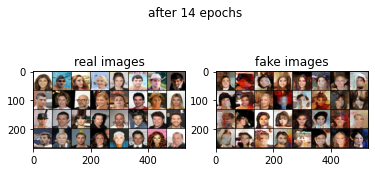

epoch:15/50 iteration:0/202599 Loss C :-2.333834171295166 -- Loss G :-4.352211952209473
epoch:15/50 iteration:100/202599 Loss C :-1.8338905572891235 -- Loss G :-7.057292938232422
epoch:15/50 iteration:200/202599 Loss C :-1.6421986818313599 -- Loss G :-2.814274787902832
epoch:15/50 iteration:300/202599 Loss C :-0.60197913646698 -- Loss G :-1.862668514251709
epoch:15/50 iteration:400/202599 Loss C :-1.8877394199371338 -- Loss G :-5.309745788574219
epoch:15/50 iteration:500/202599 Loss C :-0.02995350956916809 -- Loss G :-4.098874568939209
epoch:15/50 iteration:600/202599 Loss C :-1.161595106124878 -- Loss G :-8.53546142578125
epoch:15/50 iteration:700/202599 Loss C :-3.71962308883667 -- Loss G :-1.1272701025009155
epoch:15/50 iteration:800/202599 Loss C :-1.1546571254730225 -- Loss G :3.4611949920654297
epoch:15/50 iteration:900/202599 Loss C :0.5222258567810059 -- Loss G :-0.6704925298690796
epoch:15/50 iteration:1000/202599 Loss C :-0.7447224855422974 -- Loss G :4.1302103996276855
epoch

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

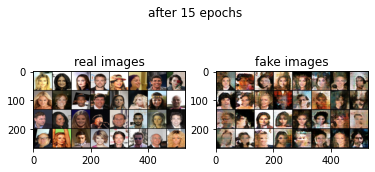

epoch:16/50 iteration:0/202599 Loss C :-0.7839679718017578 -- Loss G :-1.190504789352417
epoch:16/50 iteration:100/202599 Loss C :0.8129854202270508 -- Loss G :2.433682441711426
epoch:16/50 iteration:200/202599 Loss C :-0.9301735162734985 -- Loss G :6.854414939880371
epoch:16/50 iteration:300/202599 Loss C :-2.0404937267303467 -- Loss G :-10.343406677246094
epoch:16/50 iteration:400/202599 Loss C :1.3060758113861084 -- Loss G :-9.988279342651367
epoch:16/50 iteration:500/202599 Loss C :1.1165053844451904 -- Loss G :-5.660359859466553
epoch:16/50 iteration:600/202599 Loss C :-0.49875813722610474 -- Loss G :-3.795429229736328
epoch:16/50 iteration:700/202599 Loss C :-1.2508262395858765 -- Loss G :-18.268524169921875
epoch:16/50 iteration:800/202599 Loss C :0.28410109877586365 -- Loss G :-8.348196029663086
epoch:16/50 iteration:900/202599 Loss C :1.1480978727340698 -- Loss G :-11.025242805480957
epoch:16/50 iteration:1000/202599 Loss C :-0.8696958422660828 -- Loss G :-4.913506507873535
ep

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

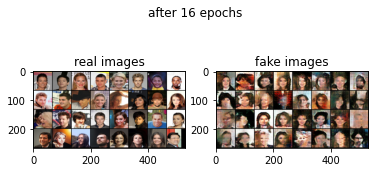

epoch:17/50 iteration:0/202599 Loss C :0.10397800803184509 -- Loss G :-2.1418983936309814
epoch:17/50 iteration:100/202599 Loss C :0.4715650677680969 -- Loss G :-17.999691009521484
epoch:17/50 iteration:200/202599 Loss C :0.7735605239868164 -- Loss G :-10.719067573547363
epoch:17/50 iteration:300/202599 Loss C :-0.933464765548706 -- Loss G :-10.16948127746582
epoch:17/50 iteration:400/202599 Loss C :-1.0331422090530396 -- Loss G :-14.212459564208984
epoch:17/50 iteration:500/202599 Loss C :0.5597914457321167 -- Loss G :-12.153931617736816
epoch:17/50 iteration:600/202599 Loss C :-0.09925094991922379 -- Loss G :-10.30801010131836
epoch:17/50 iteration:700/202599 Loss C :0.07537492364645004 -- Loss G :-4.580045223236084
epoch:17/50 iteration:800/202599 Loss C :-1.7530336380004883 -- Loss G :12.556859016418457
epoch:17/50 iteration:900/202599 Loss C :0.13053660094738007 -- Loss G :-3.9421226978302
epoch:17/50 iteration:1000/202599 Loss C :-1.4837589263916016 -- Loss G :-5.041838645935059


<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

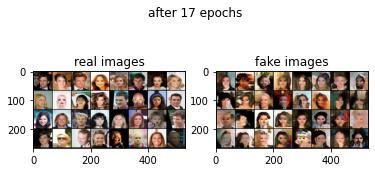

epoch:18/50 iteration:0/202599 Loss C :-0.994642972946167 -- Loss G :1.439537525177002
epoch:18/50 iteration:100/202599 Loss C :0.337991863489151 -- Loss G :-10.180915832519531
epoch:18/50 iteration:200/202599 Loss C :-0.7355601787567139 -- Loss G :-13.48021125793457
epoch:18/50 iteration:300/202599 Loss C :-0.6112134456634521 -- Loss G :-25.577831268310547
epoch:18/50 iteration:400/202599 Loss C :-0.34055233001708984 -- Loss G :-8.153740882873535
epoch:18/50 iteration:500/202599 Loss C :-1.926771640777588 -- Loss G :-1.5056849718093872
epoch:18/50 iteration:600/202599 Loss C :0.19337452948093414 -- Loss G :-16.446666717529297
epoch:18/50 iteration:700/202599 Loss C :-0.758719801902771 -- Loss G :-9.525439262390137
epoch:18/50 iteration:800/202599 Loss C :-0.5040925145149231 -- Loss G :-12.555095672607422
epoch:18/50 iteration:900/202599 Loss C :-2.6459407806396484 -- Loss G :-3.5539677143096924
epoch:18/50 iteration:1000/202599 Loss C :-1.1616778373718262 -- Loss G :-11.31282615661621

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

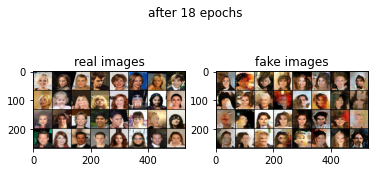

epoch:19/50 iteration:0/202599 Loss C :-0.09252450615167618 -- Loss G :-8.004318237304688
epoch:19/50 iteration:100/202599 Loss C :2.7400577068328857 -- Loss G :6.061763286590576
epoch:19/50 iteration:200/202599 Loss C :0.10758207738399506 -- Loss G :0.7389494180679321
epoch:19/50 iteration:300/202599 Loss C :-1.3743852376937866 -- Loss G :3.221831798553467
epoch:19/50 iteration:400/202599 Loss C :-0.4516470730304718 -- Loss G :3.8236677646636963
epoch:19/50 iteration:500/202599 Loss C :-2.115248918533325 -- Loss G :4.111329078674316
epoch:19/50 iteration:600/202599 Loss C :0.0504862442612648 -- Loss G :-1.309611439704895
epoch:19/50 iteration:700/202599 Loss C :-1.9870469570159912 -- Loss G :-13.998199462890625
epoch:19/50 iteration:800/202599 Loss C :-1.2854186296463013 -- Loss G :-7.771239280700684
epoch:19/50 iteration:900/202599 Loss C :-1.1386518478393555 -- Loss G :-18.90140151977539
epoch:19/50 iteration:1000/202599 Loss C :0.4063994288444519 -- Loss G :-23.73224639892578
epoch

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

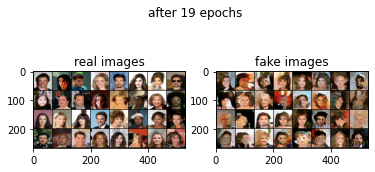

epoch:20/50 iteration:0/202599 Loss C :-0.413646399974823 -- Loss G :-13.75947380065918
epoch:20/50 iteration:100/202599 Loss C :0.3913175165653229 -- Loss G :-12.817716598510742
epoch:20/50 iteration:200/202599 Loss C :-1.121473789215088 -- Loss G :4.939993858337402
epoch:20/50 iteration:300/202599 Loss C :-0.4768865704536438 -- Loss G :0.0682092010974884
epoch:20/50 iteration:400/202599 Loss C :0.3757422864437103 -- Loss G :-0.13043896853923798
epoch:20/50 iteration:500/202599 Loss C :-3.0243051052093506 -- Loss G :-5.328280925750732
epoch:20/50 iteration:600/202599 Loss C :0.4290351867675781 -- Loss G :-6.921111106872559
epoch:20/50 iteration:700/202599 Loss C :0.5469651222229004 -- Loss G :-9.595452308654785
epoch:20/50 iteration:800/202599 Loss C :-0.40728431940078735 -- Loss G :3.33178973197937
epoch:20/50 iteration:900/202599 Loss C :-0.963655948638916 -- Loss G :-6.899290084838867
epoch:20/50 iteration:1000/202599 Loss C :0.6933692097663879 -- Loss G :-8.256366729736328
epoch:2

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

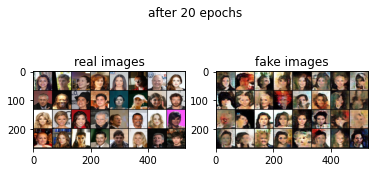

epoch:21/50 iteration:0/202599 Loss C :-0.2463665008544922 -- Loss G :-5.108906269073486
epoch:21/50 iteration:100/202599 Loss C :-0.3897795081138611 -- Loss G :3.0862174034118652
epoch:21/50 iteration:200/202599 Loss C :-0.6408424973487854 -- Loss G :7.055062770843506
epoch:21/50 iteration:300/202599 Loss C :-0.08187906444072723 -- Loss G :2.668992519378662
epoch:21/50 iteration:400/202599 Loss C :-0.6617200970649719 -- Loss G :-0.04835313558578491
epoch:21/50 iteration:500/202599 Loss C :-1.3435370922088623 -- Loss G :-1.192624807357788
epoch:21/50 iteration:600/202599 Loss C :-1.6664358377456665 -- Loss G :-1.227599024772644
epoch:21/50 iteration:700/202599 Loss C :0.31364721059799194 -- Loss G :-16.18984031677246
epoch:21/50 iteration:800/202599 Loss C :0.32553771138191223 -- Loss G :-5.258656978607178
epoch:21/50 iteration:900/202599 Loss C :-2.0130133628845215 -- Loss G :-3.418910264968872
epoch:21/50 iteration:1000/202599 Loss C :-2.1884047985076904 -- Loss G :-7.916958332061768

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

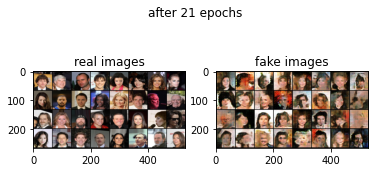

epoch:22/50 iteration:0/202599 Loss C :-0.8910213708877563 -- Loss G :-3.842900514602661
epoch:22/50 iteration:100/202599 Loss C :-3.7412075996398926 -- Loss G :-8.993370056152344
epoch:22/50 iteration:200/202599 Loss C :0.307681143283844 -- Loss G :1.8490105867385864
epoch:22/50 iteration:300/202599 Loss C :0.07012397795915604 -- Loss G :13.443788528442383
epoch:22/50 iteration:400/202599 Loss C :-1.7610366344451904 -- Loss G :4.102495193481445
epoch:22/50 iteration:500/202599 Loss C :-0.7181962132453918 -- Loss G :9.150428771972656
epoch:22/50 iteration:600/202599 Loss C :-0.5980097055435181 -- Loss G :14.325216293334961
epoch:22/50 iteration:700/202599 Loss C :1.3239587545394897 -- Loss G :7.636165618896484
epoch:22/50 iteration:800/202599 Loss C :-0.9621772766113281 -- Loss G :8.379236221313477
epoch:22/50 iteration:900/202599 Loss C :0.6087433695793152 -- Loss G :4.0218400955200195
epoch:22/50 iteration:1000/202599 Loss C :-2.0746562480926514 -- Loss G :1.6562297344207764
epoch:22

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

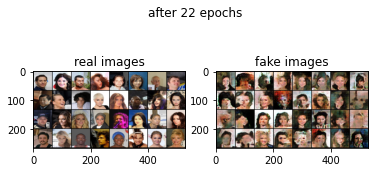

epoch:23/50 iteration:0/202599 Loss C :-2.979501247406006 -- Loss G :-1.8270206451416016
epoch:23/50 iteration:100/202599 Loss C :0.42909619212150574 -- Loss G :7.564410209655762
epoch:23/50 iteration:200/202599 Loss C :0.034718163311481476 -- Loss G :-3.5286967754364014
epoch:23/50 iteration:300/202599 Loss C :0.03452896699309349 -- Loss G :-0.35695695877075195
epoch:23/50 iteration:400/202599 Loss C :-0.3009035289287567 -- Loss G :5.789494514465332
epoch:23/50 iteration:500/202599 Loss C :0.9132100939750671 -- Loss G :1.2506077289581299
epoch:23/50 iteration:600/202599 Loss C :0.12279536575078964 -- Loss G :-1.167604923248291
epoch:23/50 iteration:700/202599 Loss C :0.8563558459281921 -- Loss G :7.297717571258545
epoch:23/50 iteration:800/202599 Loss C :0.4617423415184021 -- Loss G :5.228193283081055
epoch:23/50 iteration:900/202599 Loss C :-0.7290284633636475 -- Loss G :-4.210855960845947
epoch:23/50 iteration:1000/202599 Loss C :-1.2789987325668335 -- Loss G :-7.553221702575684
epo

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

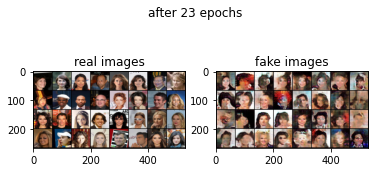

epoch:24/50 iteration:0/202599 Loss C :-1.089415192604065 -- Loss G :-15.062752723693848
epoch:24/50 iteration:100/202599 Loss C :-0.6655895113945007 -- Loss G :-16.068099975585938
epoch:24/50 iteration:200/202599 Loss C :-1.0306081771850586 -- Loss G :-3.8290212154388428
epoch:24/50 iteration:300/202599 Loss C :-0.4611344337463379 -- Loss G :1.352630376815796
epoch:24/50 iteration:400/202599 Loss C :0.5734289884567261 -- Loss G :-11.281078338623047
epoch:24/50 iteration:500/202599 Loss C :0.14640764892101288 -- Loss G :-3.6260218620300293
epoch:24/50 iteration:600/202599 Loss C :-1.3556970357894897 -- Loss G :1.1653597354888916
epoch:24/50 iteration:700/202599 Loss C :1.9208624362945557 -- Loss G :2.1503474712371826
epoch:24/50 iteration:800/202599 Loss C :-0.4429737329483032 -- Loss G :-5.544369220733643
epoch:24/50 iteration:900/202599 Loss C :-1.6750590801239014 -- Loss G :-0.052735865116119385
epoch:24/50 iteration:1000/202599 Loss C :0.054148051887750626 -- Loss G :6.015815734863

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

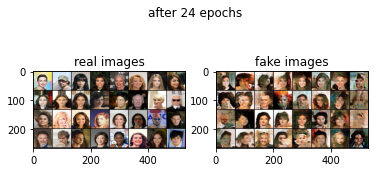

epoch:25/50 iteration:0/202599 Loss C :-0.46631506085395813 -- Loss G :-5.510818004608154
epoch:25/50 iteration:100/202599 Loss C :-2.0642833709716797 -- Loss G :-4.886013031005859
epoch:25/50 iteration:200/202599 Loss C :0.02752526104450226 -- Loss G :-14.263591766357422
epoch:25/50 iteration:300/202599 Loss C :0.6795729994773865 -- Loss G :-20.10713005065918
epoch:25/50 iteration:400/202599 Loss C :-0.7406551837921143 -- Loss G :-5.144168853759766
epoch:25/50 iteration:500/202599 Loss C :-0.6659076809883118 -- Loss G :-9.502655029296875
epoch:25/50 iteration:600/202599 Loss C :-0.11275441199541092 -- Loss G :-15.336336135864258
epoch:25/50 iteration:700/202599 Loss C :-0.7535080909729004 -- Loss G :-6.245954513549805
epoch:25/50 iteration:800/202599 Loss C :-1.1358369588851929 -- Loss G :4.820847511291504
epoch:25/50 iteration:900/202599 Loss C :0.23313826322555542 -- Loss G :-7.180523872375488
epoch:25/50 iteration:1000/202599 Loss C :-1.2891571521759033 -- Loss G :-17.1816368103027

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

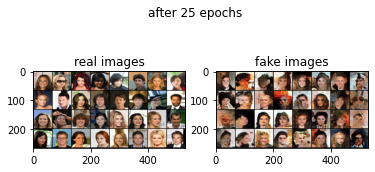

epoch:26/50 iteration:0/202599 Loss C :-0.4616873562335968 -- Loss G :-15.709656715393066
epoch:26/50 iteration:100/202599 Loss C :-1.169008493423462 -- Loss G :-19.587745666503906
epoch:26/50 iteration:200/202599 Loss C :-2.4117801189422607 -- Loss G :-9.519676208496094
epoch:26/50 iteration:300/202599 Loss C :-0.14453859627246857 -- Loss G :-15.097509384155273
epoch:26/50 iteration:400/202599 Loss C :-0.6034287214279175 -- Loss G :-13.31494140625
epoch:26/50 iteration:500/202599 Loss C :-0.020996611565351486 -- Loss G :-23.90997314453125
epoch:26/50 iteration:600/202599 Loss C :-1.6728191375732422 -- Loss G :-12.79138469696045
epoch:26/50 iteration:700/202599 Loss C :-2.4548141956329346 -- Loss G :-5.841771125793457
epoch:26/50 iteration:800/202599 Loss C :-0.39345231652259827 -- Loss G :2.414806842803955
epoch:26/50 iteration:900/202599 Loss C :-0.4493820369243622 -- Loss G :-2.997666120529175
epoch:26/50 iteration:1000/202599 Loss C :-0.999239444732666 -- Loss G :0.7821874022483826

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

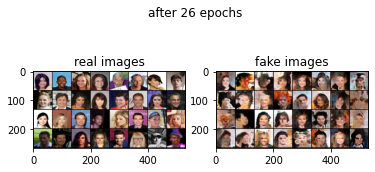

epoch:27/50 iteration:0/202599 Loss C :0.664268970489502 -- Loss G :-17.13517189025879
epoch:27/50 iteration:100/202599 Loss C :-0.7754899263381958 -- Loss G :-15.385092735290527
epoch:27/50 iteration:200/202599 Loss C :-0.6442062854766846 -- Loss G :-15.047532081604004
epoch:27/50 iteration:300/202599 Loss C :0.3266075849533081 -- Loss G :-18.225948333740234
epoch:27/50 iteration:400/202599 Loss C :-1.1592336893081665 -- Loss G :-4.884963512420654
epoch:27/50 iteration:500/202599 Loss C :-0.3977624773979187 -- Loss G :6.402237892150879
epoch:27/50 iteration:600/202599 Loss C :1.1074316501617432 -- Loss G :4.484874725341797
epoch:27/50 iteration:700/202599 Loss C :1.0057634115219116 -- Loss G :-6.7736406326293945
epoch:27/50 iteration:800/202599 Loss C :0.2961713969707489 -- Loss G :2.6446805000305176
epoch:27/50 iteration:900/202599 Loss C :0.3686985373497009 -- Loss G :8.238786697387695
epoch:27/50 iteration:1000/202599 Loss C :-0.044166579842567444 -- Loss G :4.721977710723877
epoch

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

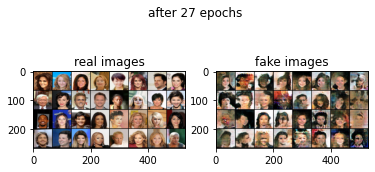

epoch:28/50 iteration:0/202599 Loss C :-0.6841594576835632 -- Loss G :-2.0121326446533203
epoch:28/50 iteration:100/202599 Loss C :-0.20334729552268982 -- Loss G :-18.17000961303711
epoch:28/50 iteration:200/202599 Loss C :-0.12487778812646866 -- Loss G :-10.311155319213867
epoch:28/50 iteration:300/202599 Loss C :-1.0502073764801025 -- Loss G :-7.449383735656738
epoch:28/50 iteration:400/202599 Loss C :-0.007986292243003845 -- Loss G :-10.828661918640137
epoch:28/50 iteration:500/202599 Loss C :-2.7501564025878906 -- Loss G :-8.946795463562012
epoch:28/50 iteration:600/202599 Loss C :-0.6027560830116272 -- Loss G :-5.281618595123291
epoch:28/50 iteration:700/202599 Loss C :-1.5187368392944336 -- Loss G :-22.000198364257812
epoch:28/50 iteration:800/202599 Loss C :-0.37634456157684326 -- Loss G :-20.321481704711914
epoch:28/50 iteration:900/202599 Loss C :0.22765952348709106 -- Loss G :-19.48434829711914
epoch:28/50 iteration:1000/202599 Loss C :-1.8412710428237915 -- Loss G :-15.22500

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

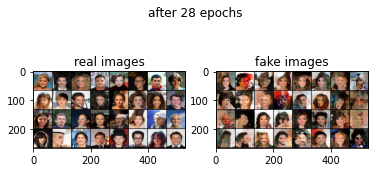

epoch:29/50 iteration:0/202599 Loss C :-0.6951146125793457 -- Loss G :-12.290584564208984
epoch:29/50 iteration:100/202599 Loss C :-1.2448863983154297 -- Loss G :-15.480289459228516
epoch:29/50 iteration:200/202599 Loss C :-0.866584062576294 -- Loss G :-19.47866439819336
epoch:29/50 iteration:300/202599 Loss C :-0.26289650797843933 -- Loss G :-5.579100608825684
epoch:29/50 iteration:400/202599 Loss C :-1.452881932258606 -- Loss G :1.5733275413513184
epoch:29/50 iteration:500/202599 Loss C :0.974027693271637 -- Loss G :-11.207952499389648
epoch:29/50 iteration:600/202599 Loss C :4.110456943511963 -- Loss G :-10.96102523803711
epoch:29/50 iteration:700/202599 Loss C :0.3332582414150238 -- Loss G :-13.26618480682373
epoch:29/50 iteration:800/202599 Loss C :1.6581873893737793 -- Loss G :-14.160484313964844
epoch:29/50 iteration:900/202599 Loss C :0.39424389600753784 -- Loss G :-12.583818435668945
epoch:29/50 iteration:1000/202599 Loss C :0.9846845865249634 -- Loss G :-14.023453712463379
ep

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

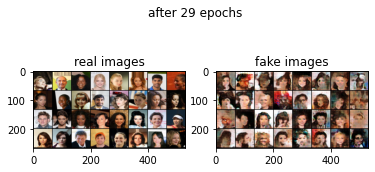

epoch:30/50 iteration:0/202599 Loss C :0.09990150481462479 -- Loss G :-0.27254730463027954
epoch:30/50 iteration:100/202599 Loss C :-0.6899659037590027 -- Loss G :-0.2666928470134735
epoch:30/50 iteration:200/202599 Loss C :1.5781481266021729 -- Loss G :-0.551997184753418
epoch:30/50 iteration:300/202599 Loss C :-1.5085291862487793 -- Loss G :-1.6069315671920776
epoch:30/50 iteration:400/202599 Loss C :-0.23442944884300232 -- Loss G :4.1966753005981445
epoch:30/50 iteration:500/202599 Loss C :-0.31409192085266113 -- Loss G :-5.065877437591553
epoch:30/50 iteration:600/202599 Loss C :1.9562047719955444 -- Loss G :-0.7866732478141785
epoch:30/50 iteration:700/202599 Loss C :-0.020693615078926086 -- Loss G :9.531519889831543
epoch:30/50 iteration:800/202599 Loss C :-1.0624668598175049 -- Loss G :6.548712730407715
epoch:30/50 iteration:900/202599 Loss C :-1.5439205169677734 -- Loss G :13.012517929077148
epoch:30/50 iteration:1000/202599 Loss C :-0.5954734683036804 -- Loss G :9.288879394531

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

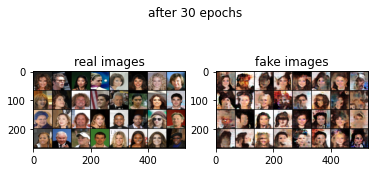

epoch:31/50 iteration:0/202599 Loss C :-1.0175881385803223 -- Loss G :6.009622573852539
epoch:31/50 iteration:100/202599 Loss C :0.11141317337751389 -- Loss G :-1.250008225440979
epoch:31/50 iteration:200/202599 Loss C :0.6765801310539246 -- Loss G :4.374483585357666
epoch:31/50 iteration:300/202599 Loss C :-0.5350967645645142 -- Loss G :4.753890037536621
epoch:31/50 iteration:400/202599 Loss C :-0.8549405932426453 -- Loss G :9.999345779418945
epoch:31/50 iteration:500/202599 Loss C :0.10229849815368652 -- Loss G :10.244806289672852
epoch:31/50 iteration:600/202599 Loss C :-0.08043929189443588 -- Loss G :0.10224629938602448
epoch:31/50 iteration:700/202599 Loss C :-2.0025858879089355 -- Loss G :17.893123626708984
epoch:31/50 iteration:800/202599 Loss C :-1.0207217931747437 -- Loss G :3.844226837158203
epoch:31/50 iteration:900/202599 Loss C :0.17468830943107605 -- Loss G :-4.490372657775879
epoch:31/50 iteration:1000/202599 Loss C :-1.4087319374084473 -- Loss G :10.743085861206055
epoc

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

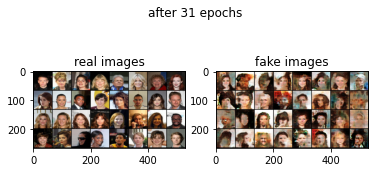

epoch:32/50 iteration:0/202599 Loss C :-0.8096732497215271 -- Loss G :26.606834411621094
epoch:32/50 iteration:100/202599 Loss C :1.0501192808151245 -- Loss G :8.84625244140625
epoch:32/50 iteration:200/202599 Loss C :-0.09552649408578873 -- Loss G :7.7613630294799805
epoch:32/50 iteration:300/202599 Loss C :-1.2395250797271729 -- Loss G :16.807004928588867
epoch:32/50 iteration:400/202599 Loss C :-0.15561291575431824 -- Loss G :9.732278823852539
epoch:32/50 iteration:500/202599 Loss C :1.022347331047058 -- Loss G :17.274368286132812
epoch:32/50 iteration:600/202599 Loss C :-0.5432415008544922 -- Loss G :28.35886001586914
epoch:32/50 iteration:700/202599 Loss C :-0.10831956565380096 -- Loss G :13.820436477661133
epoch:32/50 iteration:800/202599 Loss C :-1.0072904825210571 -- Loss G :19.99224281311035
epoch:32/50 iteration:900/202599 Loss C :-0.8091462850570679 -- Loss G :19.53942108154297
epoch:32/50 iteration:1000/202599 Loss C :0.4146212041378021 -- Loss G :24.117958068847656
epoch:3

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

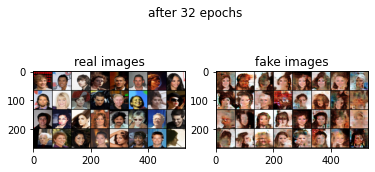

epoch:33/50 iteration:0/202599 Loss C :-2.4403555393218994 -- Loss G :0.5205649733543396
epoch:33/50 iteration:100/202599 Loss C :-1.154982089996338 -- Loss G :1.2143669128417969
epoch:33/50 iteration:200/202599 Loss C :0.34434086084365845 -- Loss G :0.9715714454650879
epoch:33/50 iteration:300/202599 Loss C :-0.8001018762588501 -- Loss G :-6.630875110626221
epoch:33/50 iteration:400/202599 Loss C :-0.31225284934043884 -- Loss G :-11.945982933044434
epoch:33/50 iteration:500/202599 Loss C :-1.6447064876556396 -- Loss G :-9.291089057922363
epoch:33/50 iteration:600/202599 Loss C :-2.54447340965271 -- Loss G :-0.6597951650619507
epoch:33/50 iteration:700/202599 Loss C :0.07374949008226395 -- Loss G :-8.609535217285156
epoch:33/50 iteration:800/202599 Loss C :-0.4111801087856293 -- Loss G :-7.615450859069824
epoch:33/50 iteration:900/202599 Loss C :0.18051737546920776 -- Loss G :1.3987243175506592
epoch:33/50 iteration:1000/202599 Loss C :0.054344628006219864 -- Loss G :-4.039947986602783

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

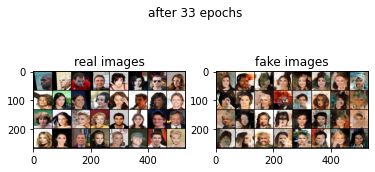

epoch:34/50 iteration:0/202599 Loss C :-0.8051090240478516 -- Loss G :-14.011703491210938
epoch:34/50 iteration:100/202599 Loss C :1.0664042234420776 -- Loss G :-15.50061321258545
epoch:34/50 iteration:200/202599 Loss C :1.1639184951782227 -- Loss G :-9.296651840209961
epoch:34/50 iteration:300/202599 Loss C :0.06002360209822655 -- Loss G :-17.813447952270508
epoch:34/50 iteration:400/202599 Loss C :-0.2833448648452759 -- Loss G :-9.355445861816406
epoch:34/50 iteration:500/202599 Loss C :0.7213312983512878 -- Loss G :-3.585946798324585
epoch:34/50 iteration:600/202599 Loss C :-0.1685575246810913 -- Loss G :0.9848695993423462
epoch:34/50 iteration:700/202599 Loss C :-0.30136731266975403 -- Loss G :8.69293212890625
epoch:34/50 iteration:800/202599 Loss C :-0.2764025926589966 -- Loss G :1.124845266342163
epoch:34/50 iteration:900/202599 Loss C :-1.5629470348358154 -- Loss G :0.06530769169330597
epoch:34/50 iteration:1000/202599 Loss C :0.6111143231391907 -- Loss G :-0.4468900263309479
ep

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

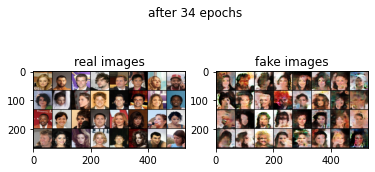

epoch:35/50 iteration:0/202599 Loss C :-0.29890432953834534 -- Loss G :-14.499677658081055
epoch:35/50 iteration:100/202599 Loss C :0.20141148567199707 -- Loss G :-5.5013933181762695
epoch:35/50 iteration:200/202599 Loss C :-0.7492744326591492 -- Loss G :-5.978721618652344
epoch:35/50 iteration:300/202599 Loss C :-0.45775923132896423 -- Loss G :2.034571886062622
epoch:35/50 iteration:400/202599 Loss C :-0.018928606063127518 -- Loss G :-1.8507965803146362
epoch:35/50 iteration:500/202599 Loss C :-0.05342056602239609 -- Loss G :-4.126222610473633
epoch:35/50 iteration:600/202599 Loss C :-1.2510536909103394 -- Loss G :-2.5437912940979004
epoch:35/50 iteration:700/202599 Loss C :-2.7800850868225098 -- Loss G :-5.568696975708008
epoch:35/50 iteration:800/202599 Loss C :-0.5997698307037354 -- Loss G :-7.523608684539795
epoch:35/50 iteration:900/202599 Loss C :0.48149171471595764 -- Loss G :-7.459060192108154
epoch:35/50 iteration:1000/202599 Loss C :-0.3901243209838867 -- Loss G :-5.11545181

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

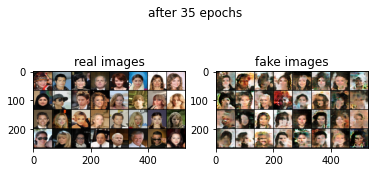

epoch:36/50 iteration:0/202599 Loss C :-0.5901241302490234 -- Loss G :-16.757841110229492
epoch:36/50 iteration:100/202599 Loss C :-1.7099558115005493 -- Loss G :-8.025594711303711
epoch:36/50 iteration:200/202599 Loss C :-0.8351541757583618 -- Loss G :-6.938724517822266
epoch:36/50 iteration:300/202599 Loss C :1.3793666362762451 -- Loss G :-14.226932525634766
epoch:36/50 iteration:400/202599 Loss C :-0.9298112392425537 -- Loss G :-14.473749160766602
epoch:36/50 iteration:500/202599 Loss C :-0.1112617701292038 -- Loss G :-13.500755310058594
epoch:36/50 iteration:600/202599 Loss C :-0.3305075168609619 -- Loss G :-9.235401153564453
epoch:36/50 iteration:700/202599 Loss C :-0.14818736910820007 -- Loss G :-4.141077518463135
epoch:36/50 iteration:800/202599 Loss C :-1.171096682548523 -- Loss G :-26.524198532104492
epoch:36/50 iteration:900/202599 Loss C :-2.359452962875366 -- Loss G :-21.129596710205078
epoch:36/50 iteration:1000/202599 Loss C :-0.9857474565505981 -- Loss G :-16.46202468872

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

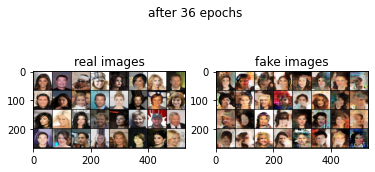

epoch:37/50 iteration:0/202599 Loss C :-1.5788627862930298 -- Loss G :-1.4553543329238892
epoch:37/50 iteration:100/202599 Loss C :0.652608335018158 -- Loss G :-19.423694610595703
epoch:37/50 iteration:200/202599 Loss C :-1.7389682531356812 -- Loss G :-9.734172821044922
epoch:37/50 iteration:300/202599 Loss C :-1.9020934104919434 -- Loss G :-10.255084037780762
epoch:37/50 iteration:400/202599 Loss C :-0.1342039853334427 -- Loss G :-20.91345977783203
epoch:37/50 iteration:500/202599 Loss C :-0.36493003368377686 -- Loss G :-21.890443801879883
epoch:37/50 iteration:600/202599 Loss C :-1.4236822128295898 -- Loss G :-26.691612243652344
epoch:37/50 iteration:700/202599 Loss C :0.46183571219444275 -- Loss G :-7.934566497802734
epoch:37/50 iteration:800/202599 Loss C :-1.1137962341308594 -- Loss G :-13.685457229614258


In [ ]:
C=Critic(img_channels,hidden_C).to(device)
G=Generator(noise_channels,img_channels,hidden_G).to(device)

#C=C.apply(init_weights)
#G=G.apply(init_weights)

wandb.watch(G, log='all', log_freq=10)
wandb.watch(C, log='all', log_freq=10)

opt_C=torch.optim.Adam(C.parameters(),lr=lr, betas=(0.5,0.999))
opt_G=torch.optim.Adam(G.parameters(),lr=lr, betas=(0.5,0.999))

gen_repeats=1
crit_repeats=3

noise_for_generate=torch.randn(batch_size,noise_channels,1,1).to(device)

losses_C=[]
losses_G=[]

for epoch in range(1,epochs+1):
  loss_C_epoch=[]
  loss_G_epoch=[]

  for idx,(x,_) in enumerate(data_loader):
    C.train()
    G.train()

    x=x.to(device)
    x_len=x.shape[0]

    ### Train C

    loss_C_iter=0
    for _ in range(crit_repeats):
      opt_C.zero_grad()
      z=torch.randn(x_len,noise_channels,1,1).to(device)

      real_imgs=x
      fake_imgs=G(z).detach()

      real_C_out=C(real_imgs)
      fake_C_out=C(fake_imgs)

      epsilon= torch.rand(len(x),1,1,1, device= device, requires_grad=True)
      gradient= get_gradient(C, real_imgs, fake_imgs.detach(), epsilon)
      gp= gradient_penalty(gradient)
      loss_C= get_crit_loss(fake_C_out, real_C_out, gp, c_lambda=10)

      loss_C.backward()
      opt_C.step()

      loss_C_iter+=loss_C.item()/crit_repeats

    ### Train G
    loss_G_iter=0
    for _ in range(gen_repeats):
      opt_G.zero_grad()
      z=torch.randn(x_len,noise_channels,1,1).to(device)
      fake_C_out = C(G(z))
      loss_G= get_gen_loss(fake_C_out)
      loss_G.backward()
      opt_G.step()

      loss_G_iter+=loss_G.item()/gen_repeats

    ### Return current state
    if idx%100==0:
      print(f'epoch:{epoch}/{epochs} iteration:{idx}/{len(dataset)} Loss C :{loss_C} -- Loss G :{loss_G}')
      artifact_G=wandb.Artifact("Generator_artifact", type='model', metadata={'epoch':epoch}, description=f"after {epoch} epochs")
      artifact_C=wandb.Artifact("Critic_artifact", type='model', metadata={'epoch':epoch}, description=f"after {epoch} epochs")

      save_model_as_checkpoint_wfdb(epoch=epoch, model=G, optimizer=opt_G, loss=loss_G, path='latest_model/checkpoint_G.pth', run=run, artifact=artifact_G)
      save_model_as_checkpoint_wfdb(epoch=epoch, model=C, optimizer=opt_C, loss=loss_C, path='latest_model/checkpoint_C.pth', run=run, artifact=artifact_C)


      with torch.no_grad():
        G.eval()
        generated=G(noise_for_generate).detach()
        img_grid_real=torchvision.utils.make_grid(x[:32]*0.5+0.5).permute(1,2,0).squeeze().cpu()
        img_grid_fake=torchvision.utils.make_grid(generated[:32]*0.5+0.5).permute(1,2,0).squeeze().cpu()

        plt.figure(figsize=(13,4))
        plt.subplot(1,2,1)
        plt.imshow(img_grid_real)
        plt.title('real images')
        plt.subplot(1,2,2)
        plt.imshow(img_grid_fake)
        plt.title('fake images')
        plt.suptitle(f'after {epoch} epochs')
        #wandb.log({"img": [wandb.Image(plt, caption=f"(after {epoch} epochs)")]})
        #wandb.log({f'{name} : output images': plt, 'epoch': epoch})
        wandb.log({f"{name} : output images : (after {epoch} epochs, idx : {idx})": plt})
        plt.clf()

    
    #if idx==2500:
    #  break

    loss_G_epoch.append(loss_G_iter)
    loss_C_epoch.append(loss_C_iter)
  losses_G.append(np.mean(loss_G_epoch))
  losses_C.append(np.mean(loss_C_epoch))

  #wandb.log({'losses_G': np.mean(loss_G_epoch), 'epoch': epoch})
  #wandb.log({'losses_C': np.mean(loss_C_epoch), 'epoch': epoch})


  # plot images for a epoch
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plt.imshow(img_grid_real)
  plt.title('real images')
  plt.subplot(1,2,2)
  plt.imshow(img_grid_fake)
  plt.title('fake images')
  plt.suptitle(f'after {epoch} epochs')
  plt.show()

  # plot losses for a epoch
  plt.figure()
  plt.plot(losses_G, label = 'Gen Loss')
  plt.plot(losses_C, label= 'Critic Loss')
  plt.title(f'after {epoch} epochs')
  wandb.log({f"losses": plt})
  plt.show()
